In [1]:
import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
matplotlib.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")
sys.path.insert(0, "../utils")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import PollingSystem as PS
import MarkovianRP as MRP
import dtr
import motion
import sim_template as sim
from importlib import reload 
import TSPN

In [2]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 8#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-71.8297512825111
SNR Threshold: 33


In [3]:
#If we're feeling it
if False:
    %store -r dt_sys AORP TSPNP tjcps pjcps qBase region pcs pfs pjcps prob_pred_con ccs cfs true_joint_con_fields tjcps

In [31]:
#Setup the communication environment:

#For now, use same channel params, basd on the San Francisco measurements
nPL = 5.2 # per SF data should be in [2, 10]
kPL = -20 # per SF data, [-20, 90]

decorrSH = 2.09    
alpha = 16 # per SF data [4,100]%too high - worse prediction
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1.5



#6 remote stations
l = 18.1
qBase = np.array([[23,20], [23-(np.sqrt(3)*l/2), 20-l/2], 
                  [27,20], [27+(np.sqrt(3)*l/2), 20-l/2],
                  [25, 20+2*np.sqrt(3)], [25,20+2*np.sqrt(3) + l]])


sub_regions = [[28,4,25,0],
               [46,22, 25, 0],
               [33, 17, 47, 17]]



cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]

x_max = 50
x_min = 0
y_max = 50
y_min = 0
region = [x_max, x_min, y_max, y_min]

#res = 2/decorrMP
res = 10
n=3
p_th = 0.5

bandwidth = 2#leave bandwidth in MHz*1000000#give ourselfes 2MHz of BW
beta = 1/(r*bandwidth)
els = [0.3/beta, 0.01/beta, 0.01/beta]

In [32]:
reload(sim)
ccs, cfs, true_joint_con_fields, tjcps = sim.create_channels(cps, region, res, GAMMA_TH, sub_regions)

Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.


In [33]:
reload(sim)
pcs, pfs, pjcps, prob_pred_con = sim.predict_channels(res, ccs, true_joint_con_fields, GAMMA_TH, p_th=p_th)

print(prob_pred_con)

Drawing 600 samples from Channel 1
Completed PredictedChannel 1
Drawing 600 samples from Channel 2
Completed PredictedChannel 2
Drawing 600 samples from Channel 3
Completed PredictedChannel 3
Drawing 600 samples from Channel 4
Completed PredictedChannel 4
Drawing 480 samples from Channel 5
Completed PredictedChannel 5
Drawing 480 samples from Channel 6
Completed PredictedChannel 6
[0.7003081664098614, 0.7727272727272727, 0.78534213268496]


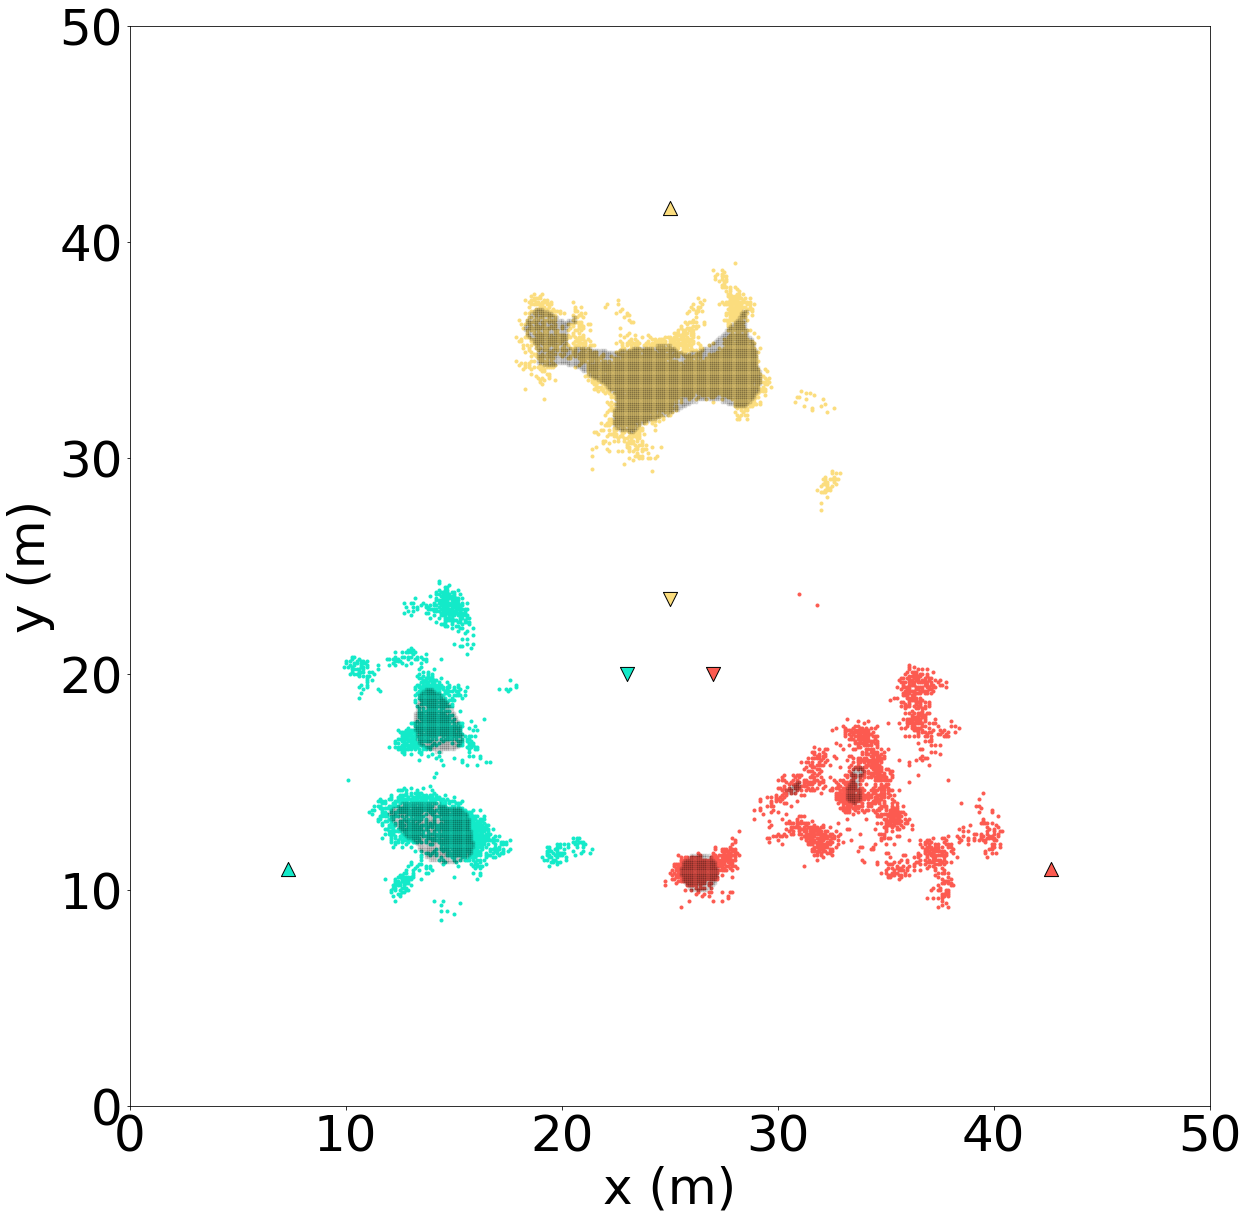

In [34]:
reload(sim)
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.gca().invert_yaxis()
plt.show()

In [47]:
#plot vs offset
import cplex_solvers as CPLX

reload(CPLX)
reload(dtr)
reload(TSPN)
reload(sim)
reload(PS)
#reload(MRP)
v = 1

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 35})

base = 0.05/beta
els = base*np.ones(3)
Ws = []
W_cys = []
n_steps = 11
l = np.reshape(np.linspace(0,50,n_steps),(n_steps,1))
offsets = -1*l*np.array([np.cos(np.pi/6), np.sin(np.pi/6)])
regions = np.reshape(np.array([x_max, x_min, y_max, y_min]), (4,1)) + np.array([np.zeros(n_steps), offsets[:,0], np.zeros(n_steps), offsets[:,1]])
regions = regions.T

n_vals = 15+1
scale = np.linspace(0.5, 2, n_vals-1)
scale = np.append(scale, 1)
dt_sys = dtr.DTR(pcs, region, els, beta, th = GAMMA_TH, p_th=p_th)
ps = dt_sys.ps

pi1s = np.zeros((n_steps, n_vals))
pi1s_obs = np.zeros((n_steps, n_vals))
pis = np.zeros((n_steps, n_vals, 3))

all_Xs = []
Ws = np.zeros((n_steps, n_vals))
# for offset, tregion in zip(offsets, regions):
for i in range(n_steps):
    offset = offsets[i]
    tregion = regions[i]
    dt_sys.shiftRegion(0, offset)
    dt_sys.region = tregion

    offset_Xs = []
    for j in range(n_vals):
        print("Iteration %d, %d"%(i,j))
        c = scale[j]
        els[0] =  c*base
        ps.Ls = els

        AORP = sim.calc_AORP(dt_sys, v)
        pi = AORP['pi']
        offset_Xs.append(AORP['X'])
        pis[i,j] = pi
        S = dtr.XtoS(AORP['X'])
        #normalize
        #get observed
        P, pi_obs = sim.pi_to_P(pi)
        pi1s_obs[i,j] = pi_obs[0]
        pi1s[i,j] = pi[0]
        w_cur = ps._calc_avg_wait_random(S, pi)
        Ws[i,j] = w_cur
        if j>0:
            #check to see if we need to do some smoothing
            
            #maybe the current one is just low, so try a couple things
            if pi1s[i,j]<pi1s[i, j-1]:
                #Check double check that we're optimal at this scale value
                AORP = sim.calc_AORP(dt_sys, v)
                pi = AORP['pi']
                S = dtr.XtoS(AORP['X'])
                
                w_cur_new = ps._calc_avg_wait_random(S, pi)
                if w_cur_new <=w_cur:
                    Ws[i,j] = w_cur_new
                    #then this is truly more optimal, and we should use it
                    pis[i,j] = pi
                    P, pi_obs = sim.pi_to_P(pi)
                    offset_Xs[-1] = AORP['X']
                    #did it increase pi[0]?
                    if pi1s[i,j] < pi[0]:
                        print("Increased pi[0] from %.4f to %.4f"%(pi1s[i,j], pi[0]))
                    #regardless, this was a beter outcome
                    pi1s[i,j] = pi[0]
                    pi1s_obs[i,j] = pi_obs[0]
                    
                #Also check to see if using a smarter start helps
                AORP = sim.calc_AORP(dt_sys, v, X0 = offset_Xs[-2])
                pi = AORP['pi']
                S = dtr.XtoS(AORP['X'])
                w_cur_new = ps._calc_avg_wait_random(S, pi)
                if w_cur_new <=w_cur:
                    Ws[i,j] = w_cur_new
                    #then this is truly more optimal, and we should use it
                    pis[i,j] = pi
                    P, pi_obs = sim.pi_to_P(pi)
                    offset_Xs[-1] = AORP['X']
                    #did it increase pi[0]?
                    if pi1s[i,j] < pi[0]:
                        print("Increased pi[0] from %.4f to %.4f"%(pi1s[i,j], pi[0]))
                    #regardless, this was a beter outcome
                    pi1s[i,j] = pi[0]
                    pi1s_obs[i,j] = pi_obs[0]
                    
                #also check that we weren't just super high last time
                c = scale[j-1]
                els[0] =  c*base
                ps.Ls = els
    
                AORP = sim.calc_AORP(dt_sys, v)
                pi = AORP['pi']
                S = dtr.XtoS(AORP['X'])
                
                w_cur_new = ps._calc_avg_wait_random(S, pi)
                if w_cur_new <=w_cur:
                    #then this is truly more optimal, and we should use it
                    pis[i,j-1] = pi
                    P, pi_obs = sim.pi_to_P(pi)
                    offset_Xs[-2] = AORP['X']
                    #did it increase pi[0]?
                    if pi1s[i,j-1] < pi[0]:
                        print("Increased pi[0] from %.4f to %.4f"%(pi1s[i,j-1], pi[0]))
                    #regardless, this was a beter outcome
                    pi1s[i,j-1] = pi[0]
                    pi1s_obs[i,j-1] = pi_obs[0]
                    
                #Also check to see if using a smarter start helps
                if j>1:
                    AORP = sim.calc_AORP(dt_sys, v, X0 = offset_Xs[-3])
                    pi = AORP['pi']
                    S = dtr.XtoS(AORP['X'])
                    w_cur_new = ps._calc_avg_wait_random(S, pi)
                    if w_cur_new <=w_cur:
                         #then this is truly more optimal, and we should use it
                        pis[i,j-1] = pi
                        P, pi_obs = sim.pi_to_P(pi)
                        offset_Xs[-2] = AORP['X']
                        #did it increase pi[0]?
                        if pi1s[i,j-1] < pi[0]:
                            print("Increased pi[0] from %.4f to %.4f"%(pi1s[i,j-1], pi[0]))
                        #regardless, this was a beter outcome
                        pi1s[i,j-1] = pi[0]
                        pi1s_obs[i,j-1] = pi_obs[0]

                c = scale[j]
                els[0] =  c*base
                ps.Ls = els
                
            if pi1s[i,j]<pi1s[i, j-1]:#if it's still not better, print out some useful info
                print("weird spike detected")
                print("params", offset, c)
                print("Previous pi", pis[i, j-1])
                print("Current pi", pis[i, j])
                print("pi[0] should increase")
                print("Previous positions: ", offset_Xs[-2])
                print("Previous dists: ", dtr.XtoS(offset_Xs[-2]))
                print("Current positions: ", offset_Xs[-1])
                print("Current dists: ", dtr.XtoS(offset_Xs[-1]))
                print("Diff caused by shift?")
                
                print("can we do better using some of the past results?")
                S_prev = dtr.XtoS(offset_Xs[-2])
                W_rnd = ps._calc_avg_wait_random(S, pi)
                print("Current Wait Time: %.4f"%(W_rnd))
                #try with previous pi
                W_rnd = ps._calc_avg_wait_random(S, pis[i, j-1])
                print("Wait Time with prev pi: %.4f"%(W_rnd))
                #try with previous S
                print("Wait time with previous S: %.4f"%(W_rnd))
                W_rnd = ps._calc_avg_wait_random(S_prev, pi)
                #try with previous pi and S
                print("Wait time with previous S and pi: %.4f"%(W_rnd))
                W_rnd = ps._calc_avg_wait_random(S_prev, pis[i, j-1])
                
                #conjecture - it's due to initizliation, so we can try to
                #1 try again
                AORP = sim.calc_AORP(dt_sys, v)
                print("Recalc'd AORP", AORP)
                #2 also look at the old scenario again - perhaps it was too high
                c = scale[j-1]
                els[0] =  c*base
                ps.Ls = els
                AORP = sim.calc_AORP(dt_sys, v)
                print("Recalc'd prev AORP", AORP)
                
                #revert back
                c = scale[j]
                els[0] =  c*base
                ps.Ls = els
                #3 try inching up the probabilites using the previous location
                pi_test = pis[i, j-1]
                for k in range(20):
                    pi_test += np.array([0.005, -.0025, -.0025])
                    W_rnd = ps._calc_avg_wait_random(S_prev, pi_test)
                    print("Wait Time with more granular pi, old positions: %.4f"%(W_rnd), pi_test)
#                 print("oops, lets try that again!")
#                 AORP = sim.calc_AORP(dt_sys, v)
#                 pi = AORP['pi']
#                 offset_Xs[-1]= AORP['X']
#                 pis[i,j] = pi
#                 S = dtr.XtoS(AORP['X'])
#                 #normalize
#                 #get observed
#                 P, pi_obs = sim.pi_to_P(pi)
#                 #pi1s[i,j] = pi_obs[0]
#                 pi1s[i,j] = pi[0]
#                 print(pi_obs[0])

    dt_sys.shiftRegion(0, -offset)#move back
    all_Xs.append(offset_Xs)

Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
8 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
8 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
14 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
8 total subregions
Iteration 0, 0
Iteration 0, 1
Iteration 0, 2


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 0, 3


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 0, 4
Iteration 0, 5


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 0, 6


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 0, 7


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 0, 8


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 0, 9


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 0, 10


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 0, 11


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 0, 12


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 0, 13


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 0, 14


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarn

Iteration 0, 15


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarn

weird spike detected
params [-0. -0.] 1.0
Previous pi [0.63979797 0.20628245 0.15391958]
Current pi [0.45384443 0.30684157 0.239314  ]
pi[0] should increase
Previous positions:  [[15.4 16.9]
 [25.6 11.3]
 [23.1 31.2]]
Previous dists:  [[ 0.         11.63615057 16.24130537]
 [11.63615057  0.         20.05642042]
 [16.24130537 20.05642042  0.        ]]
Current positions:  [[15.34578889 17.27947769]
 [25.60000012 11.30000008]
 [23.09999992 31.20000005]]
Current dists:  [[ 0.         11.87025697 15.93451384]
 [11.87025697  0.         20.05642041]
 [15.93451384 20.05642041  0.        ]]
Diff caused by shift?
can we do better using some of the past results?
Current Wait Time: 33.1896
Wait Time with prev pi: 33.1896
Wait time with previous S: 33.1896
Wait time with previous S and pi: 33.1896


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Recalc'd AORP {'WT': 32.413514101384166, 'X': array([[15.4, 16.9],
       [25.6, 11.3],
       [23.1, 31.2]]), 'pi': array([0.45967735, 0.31297463, 0.22734802])}


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Recalc'd prev AORP {'WT': 31.498555460919555, 'X': array([[15.4, 16.9],
       [25.6, 11.3],
       [23.1, 31.2]]), 'pi': array([0.63979796, 0.20628246, 0.15391958])}
Wait Time with more granular pi, old positions: 33.2288 [0.64479797 0.20378245 0.15141958]
Wait Time with more granular pi, old positions: 33.2689 [0.64979797 0.20128245 0.14891958]
Wait Time with more granular pi, old positions: 33.3101 [0.65479797 0.19878245 0.14641958]
Wait Time with more granular pi, old positions: 33.3523 [0.65979797 0.19628245 0.14391958]
Wait Time with more granular pi, old positions: 33.3956 [0.66479797 0.19378245 0.14141958]
Wait Time with more granular pi, old positions: 33.4400 [0.66979797 0.19128245 0.13891958]
Wait Time with more granular pi, old positions: 33.4855 [0.67479797 0.18878245 0.13641958]
Wait Time with more granular pi, old positions: 33.5322 [0.67979797 0.18628245 0.13391958]
Wait Time with more granular pi, old positions: 33.5801 [0.68479797 0.18378245 0.13141958]
Wait Time with

/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 1, 2


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 1, 3
Iteration 1, 4


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 1, 5


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 1, 6
Iteration 1, 7
Iteration 1, 8
Iteration 1, 9
Iteration 1, 10
Iteration 1, 11


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 1, 12


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 1, 13


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 1, 14
Iteration 1, 15


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarn

weird spike detected
params [-4.33012702 -2.5       ] 1.0
Previous pi [0.5139414  0.27881122 0.20724738]
Current pi [0.36608968 0.36904278 0.26486754]
pi[0] should increase
Previous positions:  [[10.96987298 15.1       ]
 [25.6        11.3       ]
 [23.1        31.2       ]]
Previous dists:  [[ 0.         15.1155753  20.15812445]
 [15.1155753   0.         20.05642042]
 [20.15812445 20.05642042  0.        ]]
Current positions:  [[10.96987298 15.1       ]
 [25.6        11.3       ]
 [23.1        31.2       ]]
Current dists:  [[ 0.         15.1155753  20.15812445]
 [15.1155753   0.         20.05642042]
 [20.15812445 20.05642042  0.        ]]
Diff caused by shift?
can we do better using some of the past results?
Current Wait Time: 38.8749
Wait Time with prev pi: 38.8749
Wait time with previous S: 38.8749
Wait time with previous S and pi: 38.8749


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Recalc'd AORP {'WT': 37.914250642695286, 'X': array([[10.96987298, 15.1       ],
       [25.6       , 11.3       ],
       [23.1       , 31.2       ]]), 'pi': array([0.36608968, 0.36904278, 0.26486754])}
Recalc'd prev AORP {'WT': 37.80441746274284, 'X': array([[10.96987298, 15.1       ],
       [25.6       , 11.3       ],
       [23.1       , 31.2       ]]), 'pi': array([0.5139414 , 0.27881122, 0.20724738])}
Wait Time with more granular pi, old positions: 38.9329 [0.5189414  0.27631122 0.20474738]
Wait Time with more granular pi, old positions: 38.9922 [0.5239414  0.27381122 0.20224738]
Wait Time with more granular pi, old positions: 39.0529 [0.5289414  0.27131122 0.19974738]
Wait Time with more granular pi, old positions: 39.1149 [0.5339414  0.26881122 0.19724738]
Wait Time with more granular pi, old positions: 39.1783 [0.5389414  0.26631122 0.19474738]
Wait Time with more granular pi, old positions: 39.2429 [0.5439414  0.26381122 0.19224738]
Wait Time with more granular pi, old posit

/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 2, 2
Iteration 2, 3
Iteration 2, 4


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 2, 5
Iteration 2, 6


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 2, 7
Iteration 2, 8
Iteration 2, 9


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 2, 10
Iteration 2, 11
Iteration 2, 12
Iteration 2, 13
Iteration 2, 14
Iteration 2, 15


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


weird spike detected
params [-8.66025404 -5.        ] 1.0
Previous pi [0.42806962 0.33166221 0.24026816]
Current pi [0.30213726 0.41224674 0.285616  ]
pi[0] should increase
Previous positions:  [[ 6.63974596 12.6       ]
 [25.6        11.3       ]
 [23.1        31.2       ]]
Previous dists:  [[ 0.         19.0047687  24.83747095]
 [19.0047687   0.         20.05642042]
 [24.83747095 20.05642042  0.        ]]
Current positions:  [[ 6.63974596 12.6       ]
 [25.6        11.3       ]
 [23.1        31.2       ]]
Current dists:  [[ 0.         19.0047687  24.83747095]
 [19.0047687   0.         20.05642042]
 [24.83747095 20.05642042  0.        ]]
Diff caused by shift?
can we do better using some of the past results?
Current Wait Time: 44.9449
Wait Time with prev pi: 44.9449
Wait time with previous S: 44.9449
Wait time with previous S and pi: 44.9449
Recalc'd AORP {'WT': 43.794140990492835, 'X': array([[ 6.63974596, 12.6       ],
       [25.6       , 11.3       ],
       [23.1       , 31.2     

/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 3, 1


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 3, 2


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 3, 3


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 3, 4


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 3, 5


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 3, 6


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 3, 7
Iteration 3, 8
Iteration 3, 9


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 3, 10
Iteration 3, 11


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 3, 12
Iteration 3, 13
Iteration 3, 14
Iteration 3, 15
Increased pi[0] from 0.2589 to 0.2589
weird spike detected
params [-12.99038106  -7.5       ] 1.0
Previous pi [0.36986754 0.36668035 0.2634521 ]
Current pi [0.25886574 0.44047291 0.30066135]
pi[0] should increase
Previous positions:  [[ 2.30961894 10.1       ]
 [25.6        11.3       ]
 [23.1        31.2       ]]
Previous dists:  [[ 0.         23.32127462 29.62178159]
 [23.32127462  0.         20.05642042]
 [29.62178159 20.05642042  0.        ]]
Current positions:  [[ 2.30961894 10.1       ]
 [25.6        11.3       ]
 [23.1        31.2       ]]
Current dists:  [[ 0.         23.32127462 29.62178159]
 [23.32127462  0.         20.05642042]
 [29.62178159 20.05642042  0.        ]]
Diff caused by shift?
can we do better using some of the past results?
Current Wait Time: 51.0970
Wait Time with prev pi: 51.0970
Wait time with previous S: 51.0970
Wait time with previous S and pi: 51.0970
Recalc'd AORP {'WT': 49.75765618334694, 'X

/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 4, 3
Iteration 4, 4


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 4, 5
Iteration 4, 6


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 4, 7
Iteration 4, 8
Iteration 4, 9


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 4, 10
Iteration 4, 11
Iteration 4, 12
Iteration 4, 13
Iteration 4, 14


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 4, 15


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


weird spike detected
params [-17.32050808 -10.        ] 1.0
Previous pi [0.32805525 0.39110424 0.28084051]
Current pi [0.22791876 0.45967327 0.31240797]
pi[0] should increase
Previous positions:  [[-2.02050808  7.6       ]
 [25.6        11.3       ]
 [23.1        31.2       ]]
Previous dists:  [[ 0.         27.86722926 34.46737481]
 [27.86722926  0.         20.05642042]
 [34.46737481 20.05642042  0.        ]]
Current positions:  [[-2.02050808  7.6       ]
 [25.6        11.3       ]
 [23.1        31.2       ]]
Current dists:  [[ 0.         27.86722926 34.46737481]
 [27.86722926  0.         20.05642042]
 [34.46737481 20.05642042  0.        ]]
Diff caused by shift?
can we do better using some of the past results?
Current Wait Time: 57.2401
Wait Time with prev pi: 57.2401
Wait time with previous S: 57.2401
Wait time with previous S and pi: 57.2401
Recalc'd AORP {'WT': 55.718521940989916, 'X': array([[-2.02050808,  7.6       ],
       [25.6       , 11.3       ],
       [23.1       , 31.2   

/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 5, 2


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 5, 3


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 5, 4


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 5, 5


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 5, 6


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 5, 7
Iteration 5, 8
Iteration 5, 9


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 5, 10
Iteration 5, 11
Iteration 5, 12
Iteration 5, 13
Iteration 5, 14
Iteration 5, 15


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


weird spike detected
params [-21.65063509 -12.5       ] 1.0
Previous pi [0.29651976 0.40887481 0.29460544]
Current pi [0.20467832 0.47344321 0.32187846]
pi[0] should increase
Previous positions:  [[-6.35063509  5.1       ]
 [25.6        11.3       ]
 [23.1        31.2       ]]
Previous dists:  [[ 0.         32.54662936 39.35161887]
 [32.54662936  0.         20.05642042]
 [39.35161887 20.05642042  0.        ]]
Current positions:  [[-6.35063509  5.1       ]
 [25.6        11.3       ]
 [23.1        31.2       ]]
Current dists:  [[ 0.         32.54662936 39.35161887]
 [32.54662936  0.         20.05642042]
 [39.35161887 20.05642042  0.        ]]
Diff caused by shift?
can we do better using some of the past results?
Current Wait Time: 63.3452
Wait Time with prev pi: 63.3452
Wait time with previous S: 63.3452
Wait time with previous S and pi: 63.3452


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Recalc'd AORP {'WT': 61.648940316489906, 'X': array([[-6.35063509,  5.1       ],
       [25.6       , 11.3       ],
       [23.1       , 31.2       ]]), 'pi': array([0.20467832, 0.47344323, 0.32187845])}
Recalc'd prev AORP {'WT': 64.84550623322788, 'X': array([[-6.35063509,  5.1       ],
       [25.6       , 11.3       ],
       [23.1       , 31.2       ]]), 'pi': array([0.29651976, 0.40887481, 0.29460544])}
Wait Time with more granular pi, old positions: 63.5069 [0.30151976 0.40637481 0.29210544]
Wait Time with more granular pi, old positions: 63.6733 [0.30651976 0.40387481 0.28960544]
Wait Time with more granular pi, old positions: 63.8443 [0.31151976 0.40137481 0.28710544]
Wait Time with more granular pi, old positions: 64.0195 [0.31651976 0.39887481 0.28460544]
Wait Time with more granular pi, old positions: 64.1989 [0.32151976 0.39637481 0.28210544]
Wait Time with more granular pi, old positions: 64.3823 [0.32651976 0.39387481 0.27960544]
Wait Time with more granular pi, old posit

/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 6, 2


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 6, 3


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 6, 4


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 6, 5


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 6, 6


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 6, 7


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 6, 8
Iteration 6, 9


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 6, 10
Iteration 6, 11
Iteration 6, 12
Iteration 6, 13


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 6, 14
Iteration 6, 15


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarn

weird spike detected
params [-25.98076211 -15.        ] 1.0
Previous pi [0.27184549 0.42240477 0.30574974]
Current pi [0.18652198 0.48367987 0.32979814]
pi[0] should increase
Previous positions:  [[-10.68076211   2.6       ]
 [ 25.6         11.3       ]
 [ 23.1         31.2       ]]
Previous dists:  [[ 0.         37.30929776 44.26172036]
 [37.30929776  0.         20.05642042]
 [44.26172036 20.05642042  0.        ]]
Current positions:  [[-10.68076211   2.6       ]
 [ 25.6         11.3       ]
 [ 23.1         31.2       ]]
Current dists:  [[ 0.         37.30929776 44.26172036]
 [37.30929776  0.         20.05642042]
 [44.26172036 20.05642042  0.        ]]
Diff caused by shift?
can we do better using some of the past results?
Current Wait Time: 69.4084
Wait Time with prev pi: 69.4084
Wait time with previous S: 69.4084
Wait time with previous S and pi: 69.4084


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Recalc'd AORP {'WT': 67.54151270999236, 'X': array([[-10.68076211,   2.6       ],
       [ 25.6       ,  11.3       ],
       [ 23.1       ,  31.2       ]]), 'pi': array([0.18652198, 0.48367987, 0.32979814])}
Recalc'd prev AORP {'WT': 71.51930700050491, 'X': array([[-10.68076211,   2.6       ],
       [ 25.6       ,  11.3       ],
       [ 23.1       ,  31.2       ]]), 'pi': array([0.27184549, 0.42240477, 0.30574974])}
Wait Time with more granular pi, old positions: 69.5990 [0.27684549 0.41990477 0.30324974]
Wait Time with more granular pi, old positions: 69.7953 [0.28184549 0.41740477 0.30074974]
Wait Time with more granular pi, old positions: 69.9971 [0.28684549 0.41490477 0.29824974]
Wait Time with more granular pi, old positions: 70.2042 [0.29184549 0.41240477 0.29574974]
Wait Time with more granular pi, old positions: 70.4161 [0.29684549 0.40990477 0.29324974]
Wait Time with more granular pi, old positions: 70.6328 [0.30184549 0.40740477 0.29074974]
Wait Time with more granular pi

/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 7, 5
Iteration 7, 6


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 7, 7
Iteration 7, 8
Iteration 7, 9


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 7, 10
Iteration 7, 11
Iteration 7, 12
Iteration 7, 13
Iteration 7, 14
Iteration 7, 15
weird spike detected
params [-30.31088913 -17.5       ] 1.0
Previous pi [0.25187811 0.43298964 0.31513225]
Current pi [0.17043478 0.48784771 0.34171752]
pi[0] should increase
Previous positions:  [[-15.01088913   0.1       ]
 [ 25.6         11.3       ]
 [ 23.1         31.2       ]]
Previous dists:  [[ 0.         42.12700222 49.18993668]
 [42.12700222  0.         20.05642042]
 [49.18993668 20.05642042  0.        ]]
Current positions:  [[-15.01088913   0.1       ]
 [ 26.          11.6       ]
 [ 23.1         31.2       ]]
Current dists:  [[ 0.         42.59275792 49.18993668]
 [42.59275792  0.         19.81337932]
 [49.18993668 19.81337932  0.        ]]
Diff caused by shift?
can we do better using some of the past results?
Current Wait Time: 75.4266
Wait Time with prev pi: 75.4266
Wait time with previous S: 75.4266
Wait time with previous S and pi: 75.4266


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Recalc'd AORP {'WT': 73.42728803662641, 'X': array([[-15.01088913,   0.1       ],
       [ 25.6       ,  11.3       ],
       [ 23.1       ,  31.2       ]]), 'pi': array([0.1737811 , 0.50623062, 0.31998829])}


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Recalc'd prev AORP {'WT': 78.13877090877409, 'X': array([[-15.01088913,   0.1       ],
       [ 25.6       ,  11.3       ],
       [ 23.1       ,  31.2       ]]), 'pi': array([0.25187811, 0.43298964, 0.31513225])}
Wait Time with more granular pi, old positions: 75.6466 [0.25687811 0.43048964 0.31263225]
Wait Time with more granular pi, old positions: 75.8736 [0.26187811 0.42798964 0.31013225]
Wait Time with more granular pi, old positions: 76.1070 [0.26687811 0.42548964 0.30763225]
Wait Time with more granular pi, old positions: 76.3465 [0.27187811 0.42298964 0.30513225]
Wait Time with more granular pi, old positions: 76.5919 [0.27687811 0.42048964 0.30263225]
Wait Time with more granular pi, old positions: 76.8426 [0.28187811 0.41798964 0.30013225]
Wait Time with more granular pi, old positions: 77.0986 [0.28687811 0.41548964 0.29763225]
Wait Time with more granular pi, old positions: 77.3594 [0.29187811 0.41298964 0.29513225]
Wait Time with more granular pi, old positions: 77.6248 [0

/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 8, 2
Iteration 8, 3
Iteration 8, 4


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarn

Iteration 8, 5
Iteration 8, 6


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarn

Iteration 8, 7
Iteration 8, 8
Iteration 8, 9


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 8, 10
Iteration 8, 11
Iteration 8, 12
Iteration 8, 13
Iteration 8, 14
Iteration 8, 15


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


weird spike detected
params [-34.64101615 -20.        ] 1.0
Previous pi [0.23607803 0.43751481 0.32640716]
Current pi [0.15916207 0.48886083 0.3519771 ]
pi[0] should increase
Previous positions:  [[-19.84101615  -1.4       ]
 [ 25.6         11.3       ]
 [ 23.1         31.2       ]]
Previous dists:  [[ 0.         47.18236905 53.91373543]
 [47.18236905  0.         20.05642042]
 [53.91373543 20.05642042  0.        ]]
Current positions:  [[-19.84101615  -1.4       ]
 [ 26.          11.6       ]
 [ 23.1         31.2       ]]
Current dists:  [[ 0.         47.64870158 53.91373543]
 [47.64870158  0.         19.81337932]
 [53.91373543 19.81337932  0.        ]]
Diff caused by shift?
can we do better using some of the past results?
Current Wait Time: 81.4325
Wait Time with prev pi: 81.4325
Wait time with previous S: 81.4325
Wait time with previous S and pi: 81.4325
Recalc'd AORP {'WT': 79.31407998589968, 'X': array([[-19.84101615,  -1.4       ],
       [ 26.        ,  11.6       ],
       [ 23.1

/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 9, 2


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarn

Iteration 9, 3
Iteration 9, 4
Iteration 9, 5


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 9, 6


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 9, 7
Iteration 9, 8
Iteration 9, 9
Iteration 9, 10
Iteration 9, 11
Iteration 9, 12
Iteration 9, 13
Iteration 9, 14
Iteration 9, 15


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


weird spike detected
params [-38.97114317 -22.5       ] 1.0
Previous pi [0.22208464 0.44483924 0.33307612]
Current pi [0.14904083 0.49443259 0.35652657]
pi[0] should increase
Previous positions:  [[-24.17114317  -3.9       ]
 [ 25.6         11.3       ]
 [ 23.1         31.2       ]]
Previous dists:  [[ 0.         52.04043325 58.87759316]
 [52.04043325  0.         20.05642042]
 [58.87759316 20.05642042  0.        ]]
Current positions:  [[-24.17114317  -3.9       ]
 [ 26.          11.6       ]
 [ 23.1         31.2       ]]
Current dists:  [[ 0.         52.51089037 58.87759316]
 [52.51089037  0.         19.81337932]
 [58.87759316 19.81337932  0.        ]]
Diff caused by shift?
can we do better using some of the past results?
Current Wait Time: 87.3651
Wait Time with prev pi: 87.3651
Wait time with previous S: 87.3651
Wait time with previous S and pi: 87.3651
Recalc'd AORP {'WT': 85.08359597627309, 'X': array([[-24.17114317,  -3.9       ],
       [ 26.        ,  11.6       ],
       [ 23.1

/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 10, 1
Iteration 10, 2
Iteration 10, 3


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 10, 4


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 10, 5
Iteration 10, 6


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 10, 7
Iteration 10, 8


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 10, 9
Iteration 10, 10
Iteration 10, 11
Iteration 10, 12
Iteration 10, 13
Iteration 10, 14
Iteration 10, 15


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


weird spike detected
params [-43.30127019 -25.        ] 1.0
Previous pi [0.21007236 0.45098026 0.33894738]
Current pi [0.14036417 0.49890046 0.36073538]
pi[0] should increase
Previous positions:  [[-28.50127019  -6.4       ]
 [ 25.6         11.3       ]
 [ 23.1         31.2       ]]
Previous dists:  [[ 0.         56.92308351 63.84709144]
 [56.92308351  0.         20.05642042]
 [63.84709144 20.05642042  0.        ]]
Current positions:  [[-28.50127019  -6.4       ]
 [ 26.          11.6       ]
 [ 23.1         31.2       ]]
Current dists:  [[ 0.         57.39676343 63.84709144]
 [57.39676343  0.         19.81337932]
 [63.84709144 19.81337932  0.        ]]
Diff caused by shift?
can we do better using some of the past results?
Current Wait Time: 93.2661
Wait Time with prev pi: 93.2661
Wait time with previous S: 93.2661
Wait time with previous S and pi: 93.2661


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Recalc'd AORP {'WT': 90.82606723922156, 'X': array([[-28.50127019,  -6.4       ],
       [ 26.        ,  11.6       ],
       [ 23.1       ,  31.2       ]]), 'pi': array([0.14036417, 0.49890046, 0.36073538])}
Recalc'd prev AORP {'WT': 97.71356367050336, 'X': array([[-28.50127019,  -6.4       ],
       [ 25.6       ,  11.3       ],
       [ 23.1       ,  31.2       ]]), 'pi': array([0.21007237, 0.45098026, 0.33894738])}
Wait Time with more granular pi, old positions: 93.5767 [0.21507236 0.44848026 0.33644738]
Wait Time with more granular pi, old positions: 93.8978 [0.22007236 0.44598026 0.33394738]
Wait Time with more granular pi, old positions: 94.2285 [0.22507236 0.44348026 0.33144738]
Wait Time with more granular pi, old positions: 94.5680 [0.23007236 0.44098026 0.32894738]
Wait Time with more granular pi, old positions: 94.9158 [0.23507236 0.43848026 0.32644738]
Wait Time with more granular pi, old positions: 95.2712 [0.24007236 0.43598026 0.32394738]
Wait Time with more granular pi

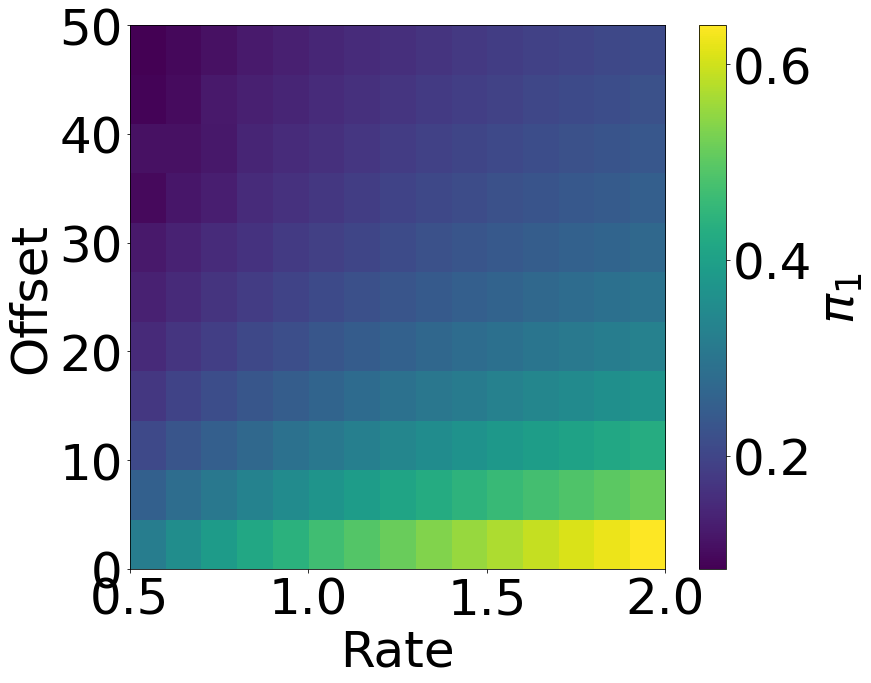

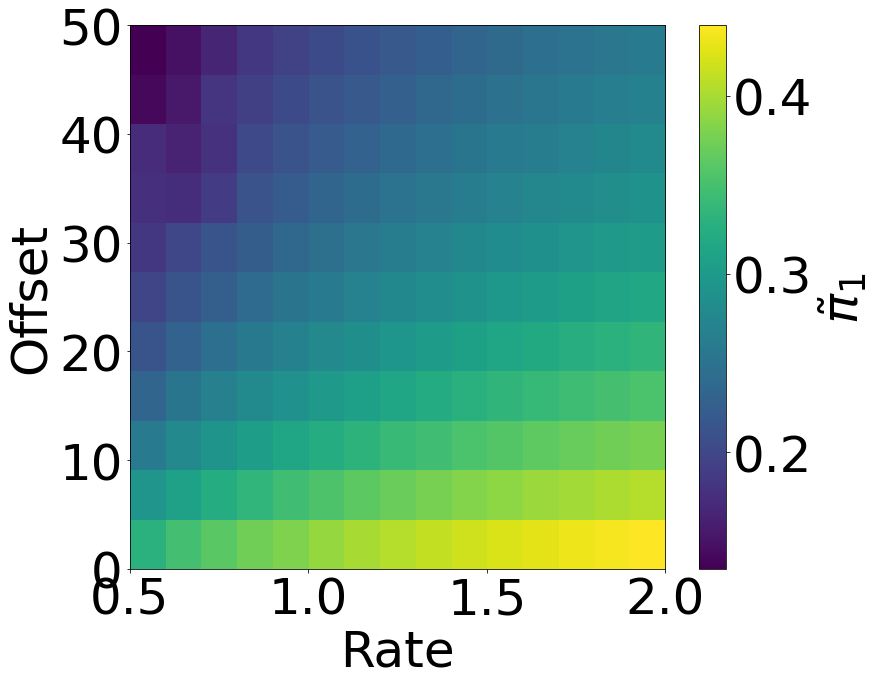

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


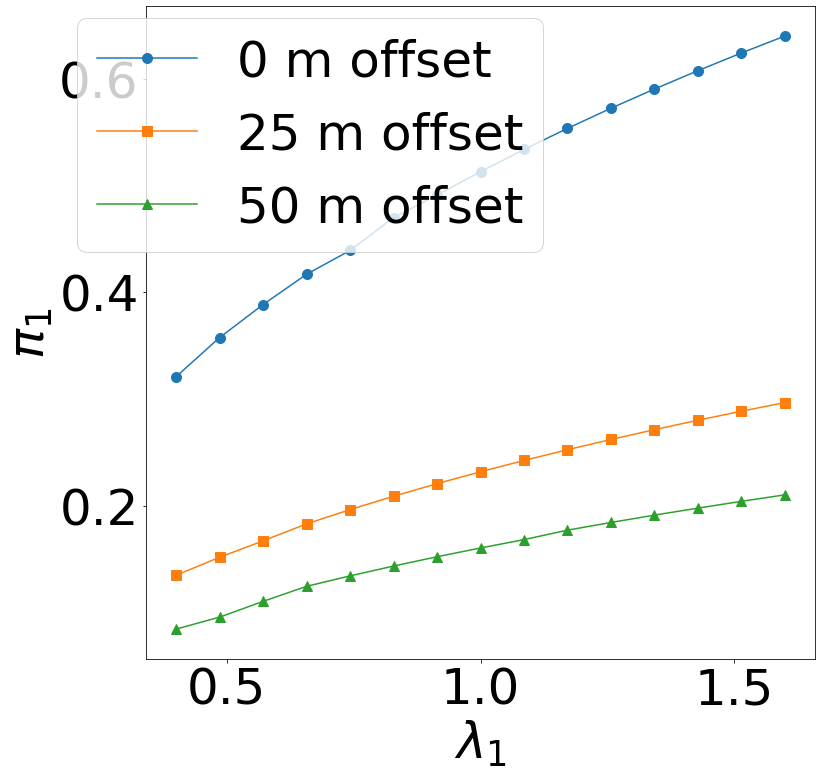

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


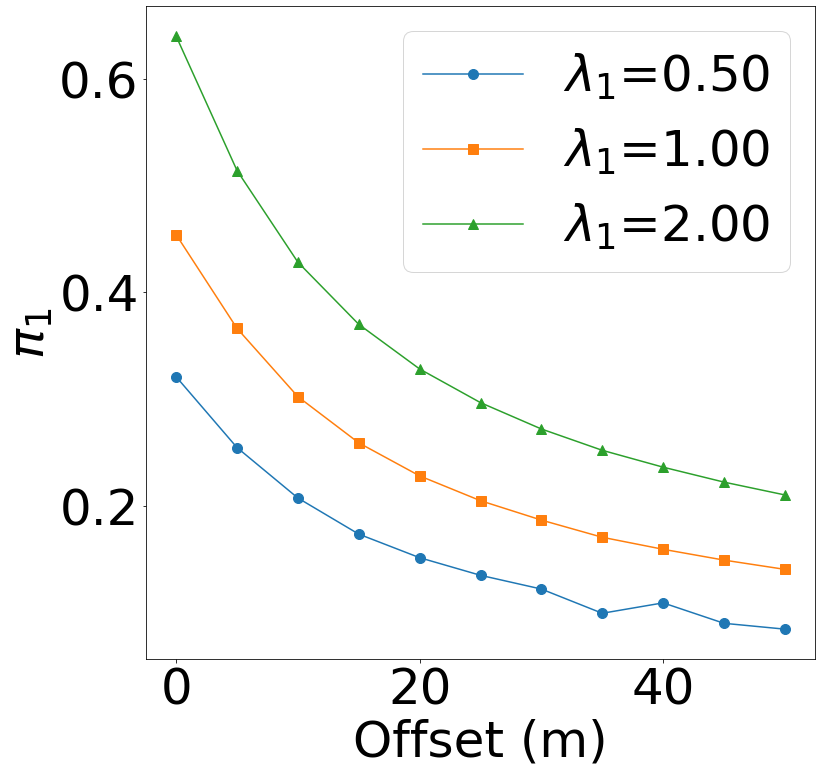

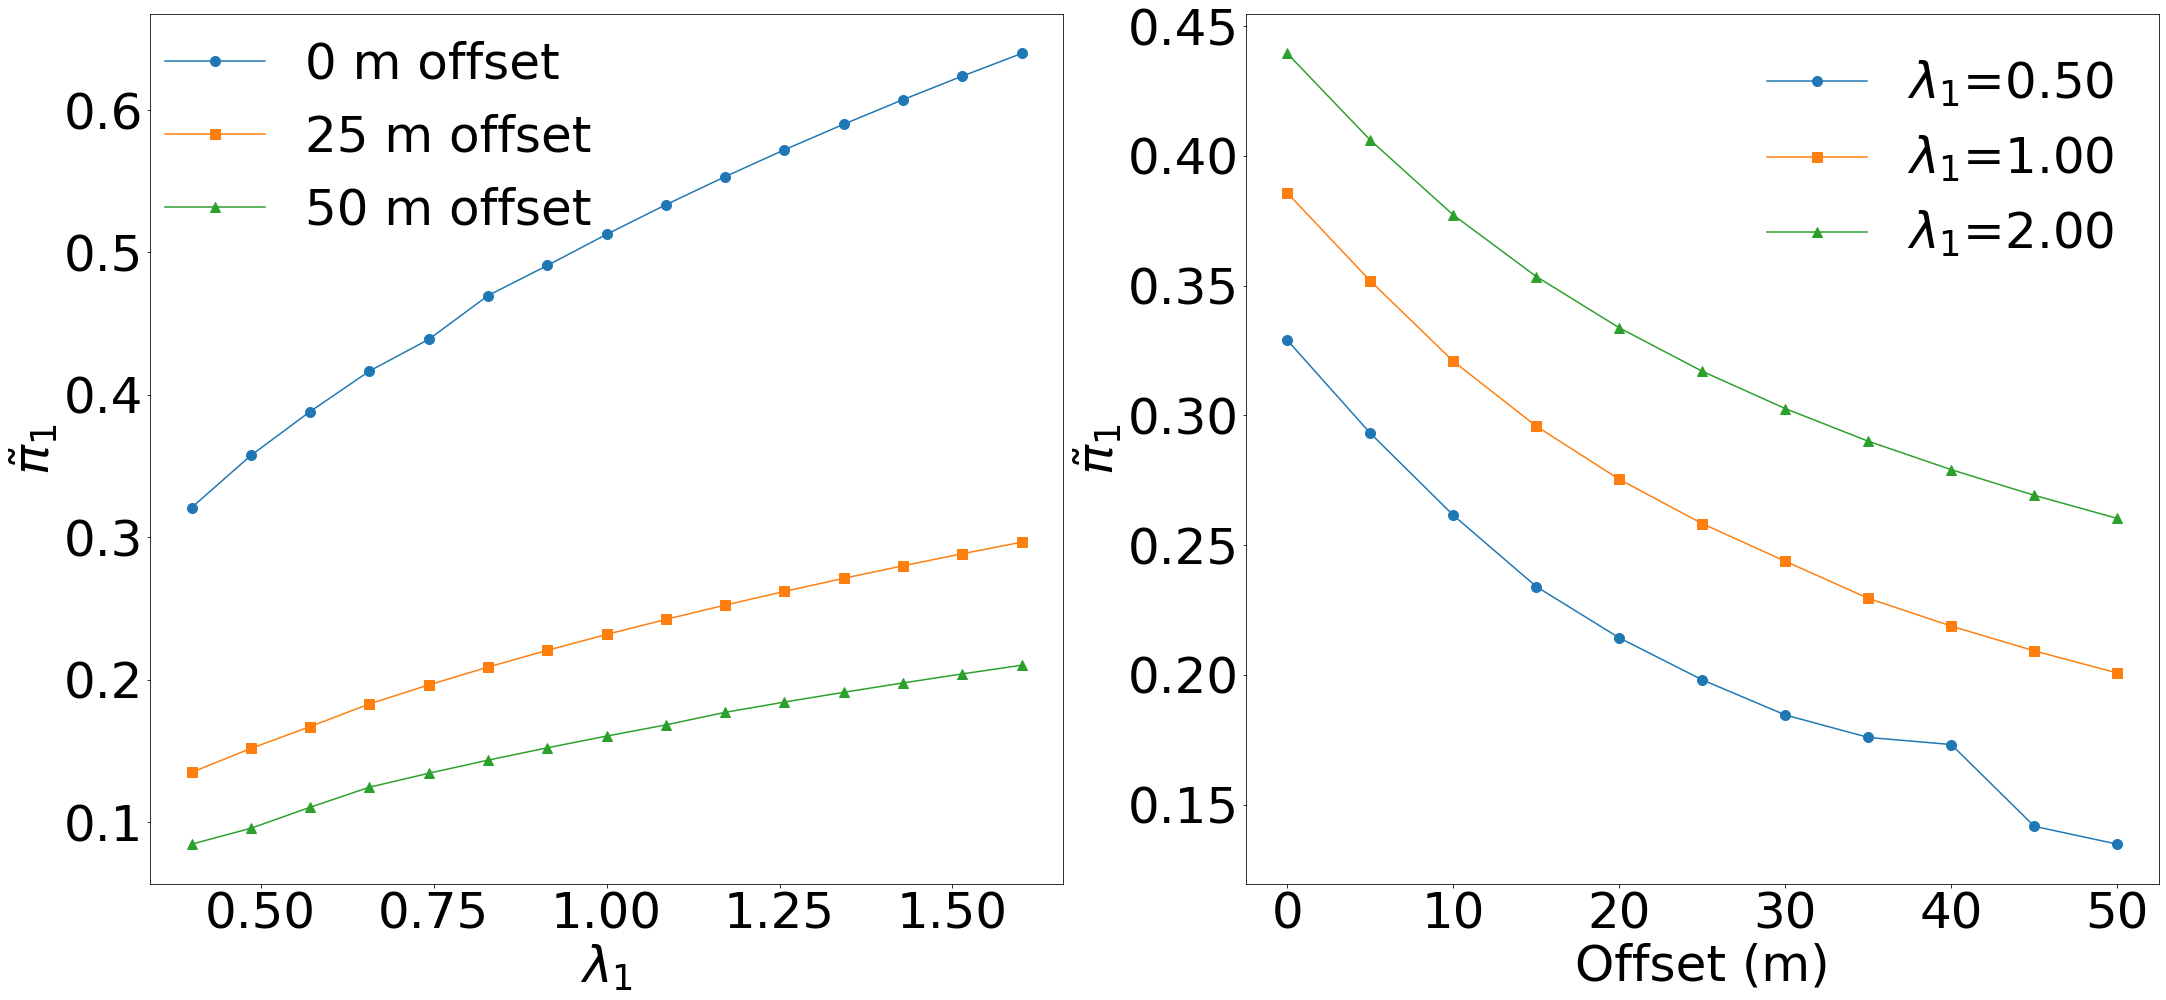

In [110]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": 50
    })

fig = plt.figure(figsize =(12,10))
im = plt.imshow(pi1s[:,:-1], origin = "lower", extent=[ scale[0], scale[-2], l[0,0], l[-1,0]], aspect = 'auto')
cb = fig.colorbar(im, label="$\\pi_1$")
plt.xlabel("Rate")
plt.ylabel("Offset")
# plt.title("Effect of Arrival Rates and Distance on AORP Visit Frequency")
plt.show()

fig = plt.figure(figsize =(12,10))
cb = plt.imshow(pi1s_obs[:,:-1], origin = "lower", extent=[ scale[0], scale[-2], l[0,0], l[-1,0]], aspect = 'auto')
fig.colorbar(cb, label = "$\\tilde{\\pi}_1$")
plt.xlabel("Rate")
plt.ylabel("Offset")
# plt.title("Effect of Arrival Rates and Distance on Observed Visit Frequency")
plt.show()




markers = ["o", "s", "^"]
ms = 10

fig = plt.figure(figsize =(12,12))
idces = [0, 5, 10]
for i in range(3):
    plt.plot(scale[:-1]*base, pi1s[idces[i],:-1], "-"+markers[i], markersize=ms, label="%d m offset"%(l[idces[i]]))
plt.ylabel("$\\pi_1$")
plt.xlabel("$\\lambda_1$")
plt.legend(loc="upper center", bbox_to_anchor=[0.245,1.021])
# plt.title("AORP Visit Frequency vs $\\lambda_1$")
plt.savefig('fig4_pi1_v_lambda.png', format='png', bbox_inches='tight')
plt.savefig('fig4_pi1_v_lambda.eps', format='eps', bbox_inches='tight')
plt.show()



fig = plt.figure(figsize =(12,12))
idces = [0, -1, -2]
for j in range(3):
    plt.plot(l, pi1s[:,idces[j]], "-"+markers[j], markersize=ms, label="$\\lambda_1$=%.2f"%(scale[idces[j]]))   
plt.ylabel("$\\pi_1$")
plt.xlabel("Offset (m)")
plt.legend()
# plt.title("AORP Visit Frequency vs Offset")
plt.savefig('fig4_pi1_v_offset.png', format='png', bbox_inches='tight')
plt.savefig('fig4_pi1_v_offset.eps', format='eps', bbox_inches='tight')
plt.show()



fig, (ax1, ax2) = plt.subplots(1,2,figsize =(36,16))
idces = [0, 5, 10]
for i in range(3):
    ax1.plot(scale[:-1]*base, pi1s[idces[i],:-1], "-"+markers[i], markersize=ms, label="%d m offset"%(l[idces[i]]))
ax1.set_ylabel("$\\tilde{\\pi}_1$")
ax1.set_xlabel("$\\lambda_1$")
ax1.legend(loc="upper center", bbox_to_anchor=[0.25,1.021], frameon=False)
# ax1.legend(loc="upper left",frameon=False)
# plt.title("Observed Visit Frequency vs $\\lambda_1$")
# plt.savefig('fig4_pi1obs_v_lambda.png', format='png', bbox_inches='tight')
# plt.savefig('fig4_pi1obs_v_lambda.eps', format='eps', bbox_inches='tight')
# plt.show()

idces = [0, -1, -2]
#fig = plt.figure(figsize =(12,12))
for j in range(3):
    ax2.plot(l, pi1s_obs[:,idces[j]], "-"+markers[j], markersize=ms, label="$\\lambda_1$=%.2f"%(scale[idces[j]]))
ax2.set_ylabel("$\\tilde{\\pi}_1$")
ax2.set_xlabel("Offset (m)")
ax2.legend(frameon = False)
#plt.title("Observed Visit Frequency vs Offset")
# plt.savefig('fig4_pi1obs_v_offset.png', format='png', bbox_inches='tight')
# plt.savefig('fig4_pi1obs_v_offset.eps', format='eps', bbox_inches='tight')
# plt.show()


fig.savefig('fig4_pi1obs_v_offset_and_lambda.png', format='png', bbox_inches='tight')
fig.savefig('fig4_pi1obs_v_offset_and_lambda.eps', format='eps', bbox_inches='tight')


In [11]:
scale

array([0.5       , 0.60714286, 0.71428571, 0.82142857, 0.92857143,
       1.03571429, 1.14285714, 1.25      , 1.35714286, 1.46428571,
       1.57142857, 1.67857143, 1.78571429, 1.89285714, 2.        ])

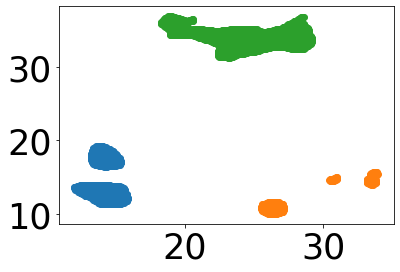

In [46]:
for Xi in dt_sys.Xis:
    pts = Xi['points']
    plt.scatter(pts[:,0], pts[:,1])